# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.metrics import mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor 


In [2]:
# Change some pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option("precision", 10)

# Data acquisition

In [3]:
# Read data
df_house = pd.read_csv("kc_house_data.csv")
df_house_date = df_house.drop(columns=['id','date'])
df_house = df_house.drop(columns=['id','zipcode','date'])

# Splite data to train and test df
df_train, df_test = train_test_split(df_house, test_size=0.3, random_state=33)

# Reset index for each df for later modification
# df_train.reset_index(drop=True, inplace=True)
# df_test.reset_index(drop=True, inplace=True)


# Edit date feature
# df_house['date'] = df_house['date'].apply(lambda item: item[:8])
# df_house['date'] = pd.to_datetime(df_house['date'], format='%Y%m%d', errors='ignore').astype('object')

# Data preparation

## Data checking
- Checking for wrong entries like symbols -,?,#,*,etc.

In [4]:
def get_values_count(data:pd.DataFrame) -> None:
    """
    Calculate the values count for each feature in the DataFrame
    
    Parameters
    ----------
    data : DataFrame
    cols : list of features
    
    Returns
    -------
    values_count : DataFrame contains values count for each feature
    """
    print("--Value counts in each features--")
    for col in data.columns:
        val_cnts = data[col].value_counts(dropna=False).to_dict()
        if(len(val_cnts)>15):
            continue
        print(f"{col} :{val_cnts}")


def get_unique_values(data:pd.DataFrame):
    """
    Get unique values in each feature
    
    Parameters
    ----------
    data : DataFrame
    cols : list of features
    
    Returns
    -------
    unique_values : DataFrame contains unique values for each feature
    """
    print("--Unique values in each features--")
    for col in data.columns:
        unique_values = data[col].unique()
        if(len(unique_values)>100):
            continue
        print(f"{col} :{unique_values}")
    

get_unique_values(df_train)


--Unique values in each features--
bedrooms :[ 2  3  4  5  1  6 33  7  0 10  8  9 11]
bathrooms :[1.   1.75 2.5  3.25 4.75 2.25 3.5  3.   0.75 2.75 2.   1.5  4.5  3.75
 4.   5.75 5.5  5.   4.25 0.   0.5  8.   5.25 1.25 6.5  6.   6.75 6.25
 7.5 ]
floors :[1.  2.  2.5 1.5 3.  3.5]
waterfront :[0 1]
view :[0 2 1 4 3]
condition :[3 4 5 2 1]
grade :[ 7  8  6  9 10  4 11  5 12 13  3  1]
yr_renovated :[   0 1988 2013 2014 1990 1989 2000 1994 2004 1983 1964 1981 2015 2005
 1982 2003 1996 1986 1998 2001 1991 1940 2008 1995 1997 2011 1968 2002
 1999 1984 1985 2007 1967 1992 2009 1945 1980 1970 1963 1975 1944 1973
 1987 1953 1977 2010 1979 2006 1976 2012 1956 1969 1950 1958 1965 1978
 1993 1948 1955 1959 1972 1960 1962 1946 1951 1974 1934]


## Missing values

In [5]:
# Remove null values if exist
print(f"--Missing values count--\n{df_train.isnull().sum().sort_values()}")

--Missing values count--
price            0
long             0
lat              0
yr_renovated     0
yr_built         0
sqft_basement    0
sqft_above       0
grade            0
condition        0
view             0
waterfront       0
floors           0
sqft_lot         0
sqft_living      0
bathrooms        0
bedrooms         0
sqft_living15    0
sqft_lot15       0
dtype: int64


<AxesSubplot:>

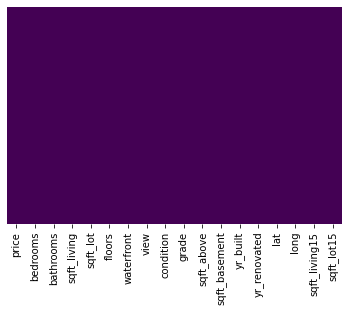

In [6]:
sns.heatmap(df_train.isnull(), yticklabels=False, cbar=False, cmap='viridis')

## Duplicates values

In [7]:
def remove_dup(data: pd.DataFrame):
    """ Remove duplicates values if exist"""
    print(f"Duplicates count before droping:{data.duplicated().sum()}")
    data.drop_duplicates(inplace=True)
    print(f"Duplicates count after droping:{data.duplicated().sum()}")
    print(f"Data dimension{data.shape}")

remove_dup(df_train)

Duplicates count before droping:3
Duplicates count after droping:0
Data dimension(15126, 18)


## Change feature data type

| Type              | Features                                                  |
| :--               | :--                                                       |
|**Categorical**    |  bedrooms, bathrooms, floors, view, waterfront, condition, grade   |
|**Continuous**     |   yr_renovated, lat, long, sqft_living, sqft_lot, sqft_above sqft_basement, yr_built, sqft_living15, sqft_lot15        |


In [8]:
# Change some features to categorical 
cols = ['bedrooms', 'bathrooms', 'floors', 'view', 'waterfront', 'condition', 'grade']
df_train[cols] = df_train[cols].astype('object')

# Select categorical data from data frame
categorical_feat = df_train.select_dtypes(include=['object']).columns
numerical_feat = df_train.select_dtypes(np.number).columns[1:]



In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15126 entries, 7543 to 2439
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          15126 non-null  float64
 1   bedrooms       15126 non-null  object 
 2   bathrooms      15126 non-null  object 
 3   sqft_living    15126 non-null  int64  
 4   sqft_lot       15126 non-null  int64  
 5   floors         15126 non-null  object 
 6   waterfront     15126 non-null  object 
 7   view           15126 non-null  object 
 8   condition      15126 non-null  object 
 9   grade          15126 non-null  object 
 10  sqft_above     15126 non-null  int64  
 11  sqft_basement  15126 non-null  int64  
 12  yr_built       15126 non-null  int64  
 13  yr_renovated   15126 non-null  int64  
 14  lat            15126 non-null  float64
 15  long           15126 non-null  float64
 16  sqft_living15  15126 non-null  int64  
 17  sqft_lot15     15126 non-null  int64  
dtypes: f

# EDA

## Statical analysis

### Numerical features
**Summary**:
- sqft_living has many outliers because there is a big distance between 75% percentile and max value
- sqft_lot has many outliers because there is a big distance between 75% percentile and max value
- sqft_basement has many outliers because there is a big distance between 75% percentile and max value

In [10]:
df_train.describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
price,15126.0,539833.7,358510.7,75000.0,323000.0,450000.0,645000.0,7700000.0
sqft_living,15126.0,2080.2,913.3,290.0,1430.0,1910.0,2560.0,13540.0
sqft_lot,15126.0,15146.0,42341.6,520.0,5025.0,7600.0,10647.5,1651359.0
sqft_above,15126.0,1793.2,829.5,290.0,1200.0,1560.0,2230.0,9410.0
sqft_basement,15126.0,287.0,438.3,0.0,0.0,0.0,550.0,4820.0
yr_built,15126.0,1970.9,29.5,1900.0,1951.0,1975.0,1997.0,2015.0
yr_renovated,15126.0,86.8,407.1,0.0,0.0,0.0,0.0,2015.0
lat,15126.0,47.6,0.1,47.2,47.5,47.6,47.7,47.8
long,15126.0,-122.2,0.1,-122.5,-122.3,-122.2,-122.1,-121.3
sqft_living15,15126.0,1985.5,683.4,460.0,1480.0,1840.0,2370.0,6110.0


### Categorical features

In [11]:
df_train.describe(include=['O']).T

,count,unique,top,freq
bedrooms,15126.0,13.0,3.0,6862.0
bathrooms,15126.0,29.0,2.5,3774.0
floors,15126.0,6.0,1.0,7413.0
waterfront,15126.0,2.0,0.0,15011.0
view,15126.0,5.0,0.0,13650.0
condition,15126.0,5.0,3.0,9819.0
grade,15126.0,12.0,7.0,6281.0


## Univariate analysis

### Numerical variables
- The target variable (price) has right skewness
- the goal is to transform the target variable to a normal distribution
- the transformation is done by the log transformation

- (lat, long) variables don't follow the normal distribution so we can apply some transformation techniques to change them into normal distribution so We can't apply log function because their PDFs aren't the same shape of (price) variable

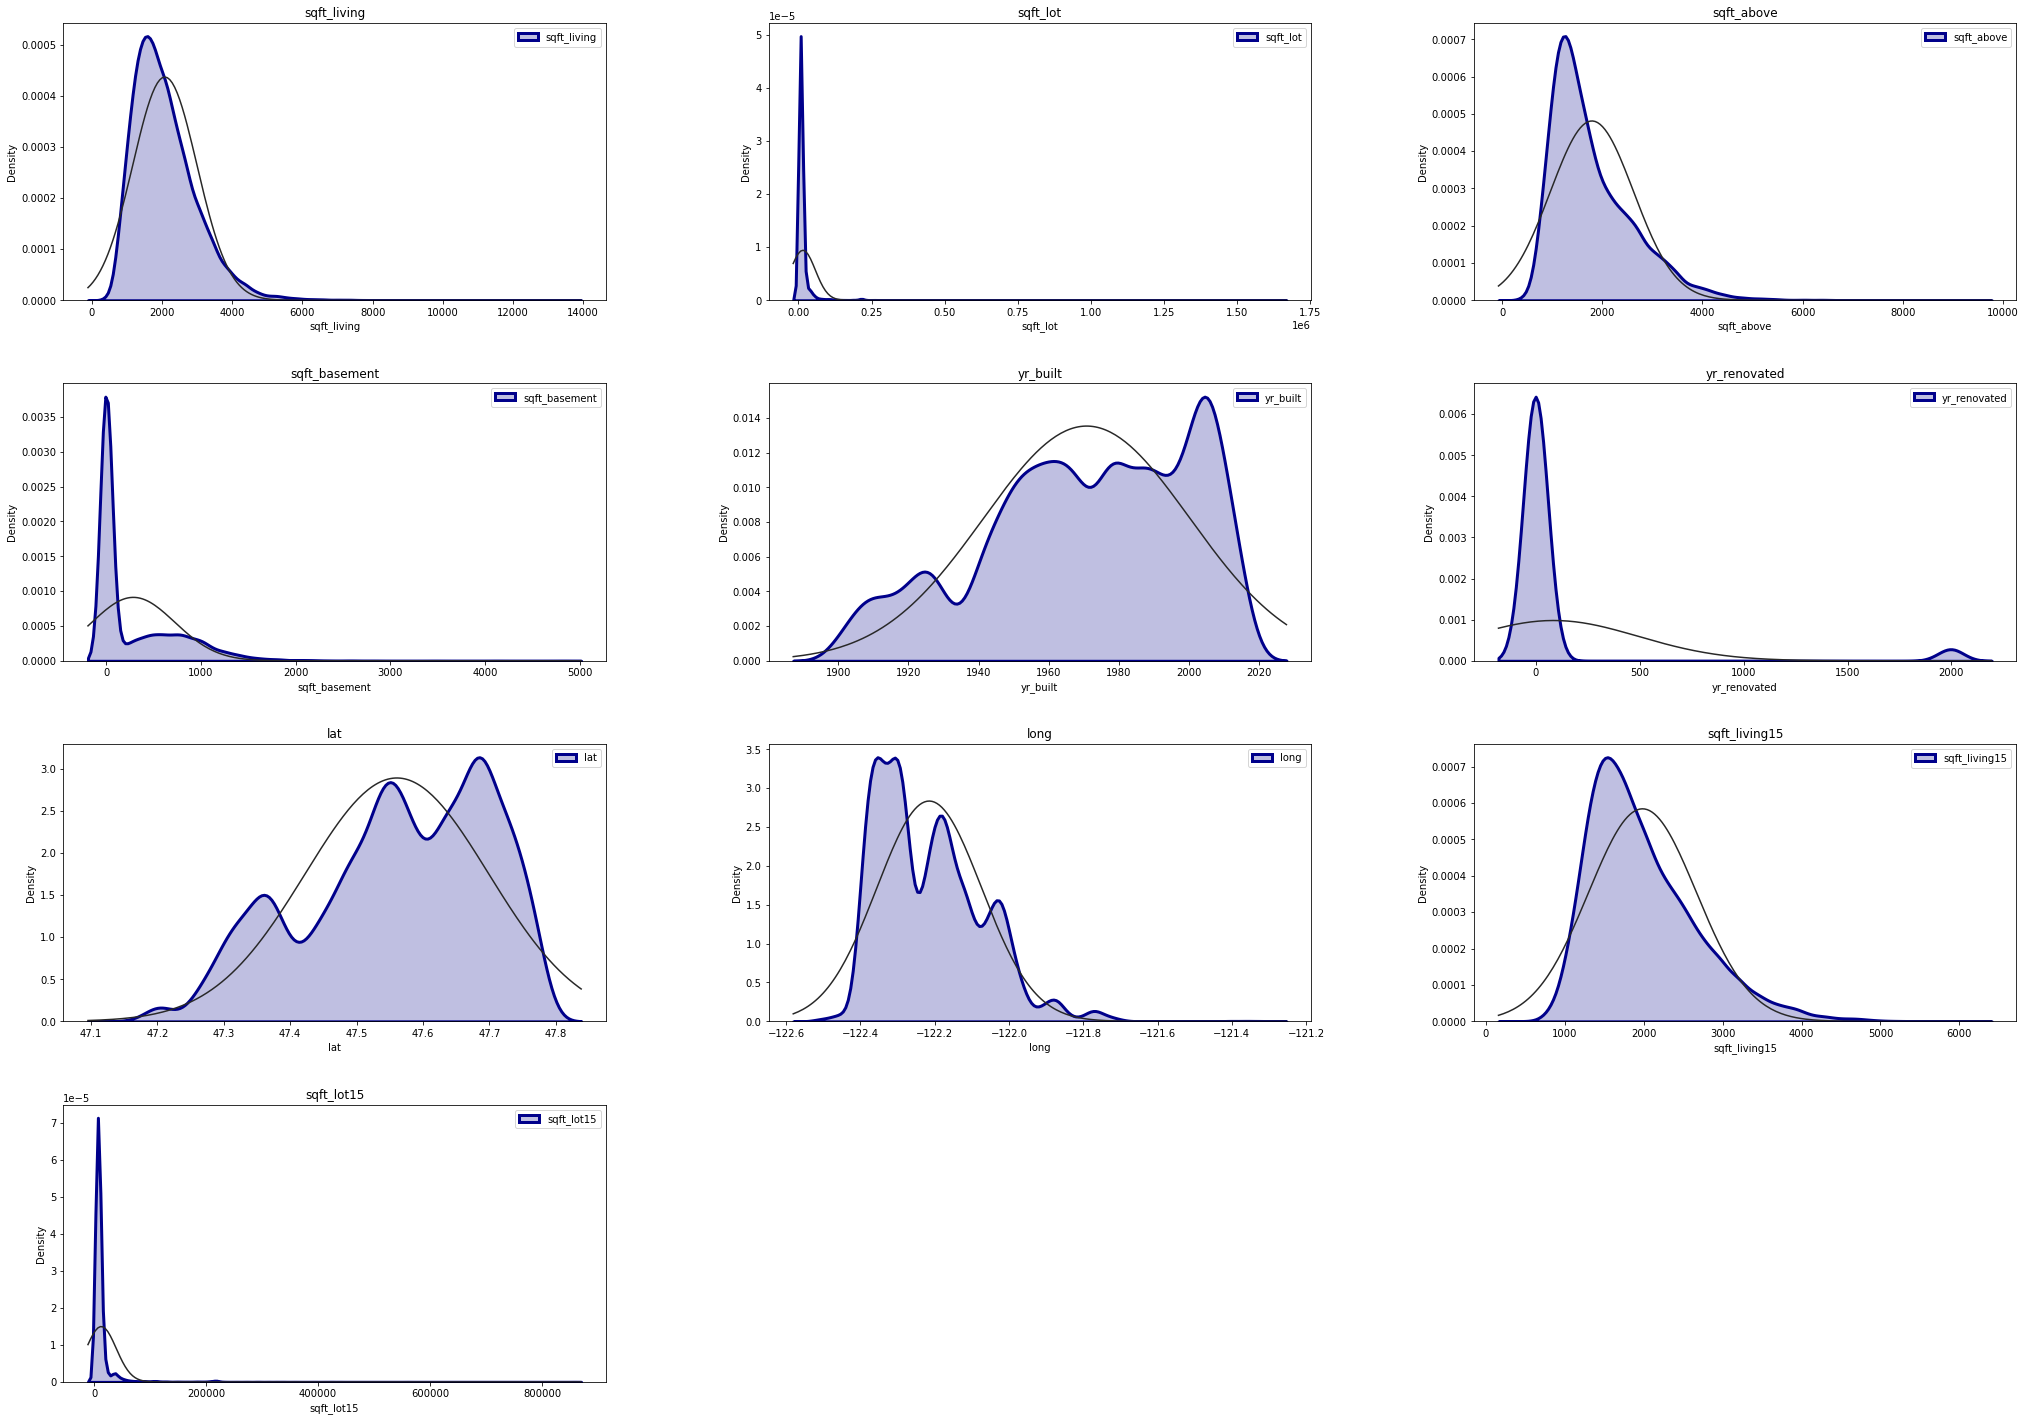

In [12]:
# plot the kde of numerical features
def plot_kde(data:pd.DataFrame, cols:list):
    """
    Plot the kde of numerical features
        
        Parameters
        ----------
        data : DataFrame
        cols : list of features
    """

    figure = plt.figure(figsize=(35,25))
    figure.subplots_adjust(wspace=0.3, hspace=0.3)
    

    for i, col in enumerate(cols, start=1):
        ax = figure.add_subplot(4, 3, i)
        sns.distplot(data[col], fit=stats.norm, hist=False, kde=True, 
                     kde_kws={'linewidth': 3, 'shade': True, 'color': 'darkblue'}, 
                     label=col, ax=ax)        
        plt.title(col)
        plt.legend()

plot_kde(df_train, numerical_feat)


### Categorical variables

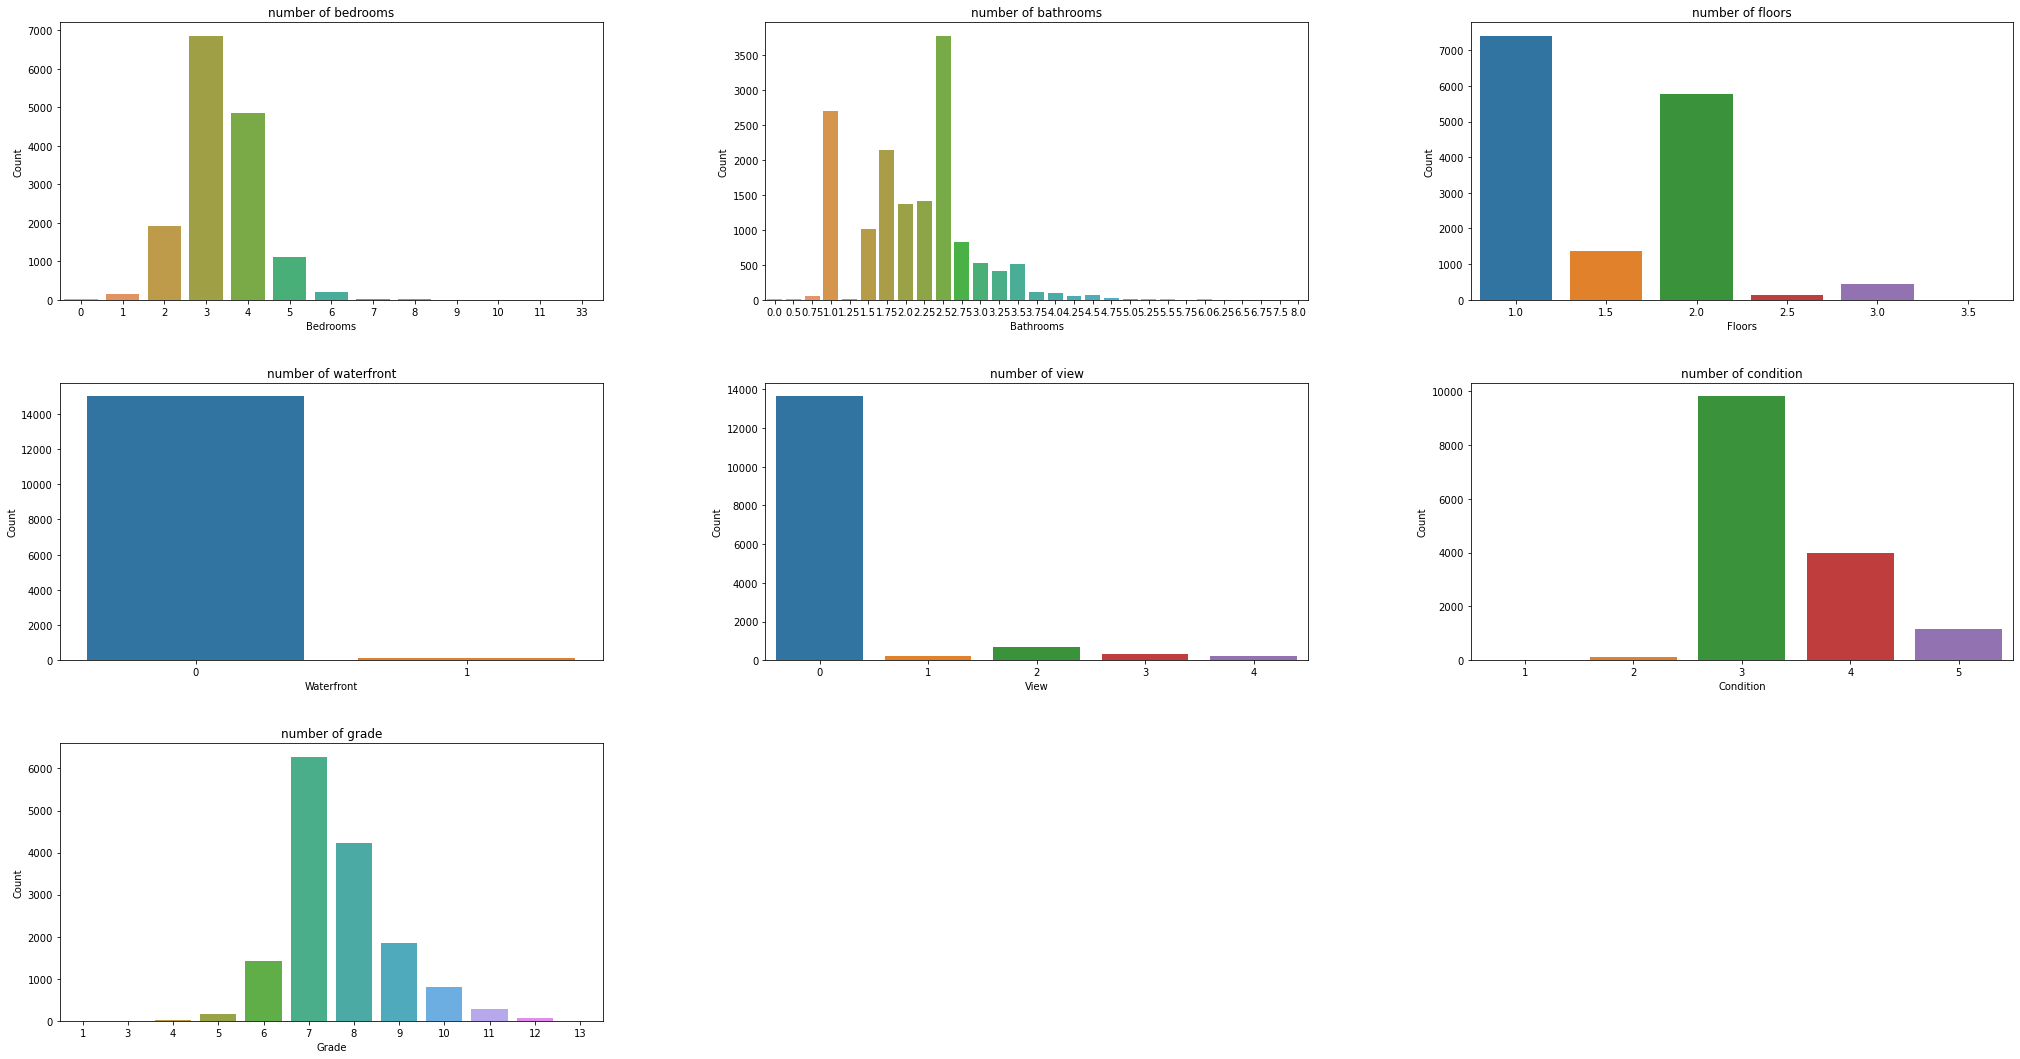

In [13]:
# plot countplot for categorical features
def plot_count_plot(data:pd.DataFrame):
    """
    Plot countplot for categorical features
    
    Parameters
    ----------
    data : DataFrame
    cols : list of features
    """
    figure = plt.figure(figsize=(35,25))
    figure.subplots_adjust(wspace=0.3, hspace=0.3)

    for i, col in enumerate(data.columns, start=1):
        ax = figure.add_subplot(4, 3, i)
        sns.countplot(x=col, data=data, ax=ax)
        ax.set_title(f'number of {col}')
        ax.set_xlabel(col.capitalize())
        ax.set_ylabel('Count')
        

plot_count_plot(df_train[categorical_feat])

## Bivariate analysis

### continuous - continuous variables

We notice that there is a good relation between **price** and **(sqft_living, sqft_living15, sqft_above, bathrooms, long)** and a poor realtion with **(lat, bathrooms, yr_built)** 

### price - continuous vars

*Correlation:*
- *Linear:*
    - There is a **positive linear correlation**  between **price** and **sqft_living** & **sqft_living15**&**sqft_above**.
    - There is **no good** correlation between **price** and **long** & **lat**.
    - There is a **good linear correlation** between **price** and **sqft_basement** but many instances have (0) value.

- *Monotonic:*
    - There is a **monotonic correlation**  between **price** and **sqft_lot** & **sqft_lot15**.

*Outliers:*
- There is a point that represents an outlier at (sqft_living > 13000) so we should deleted
- Some values have values eqaul to (0). So, that might mislead the algorithm


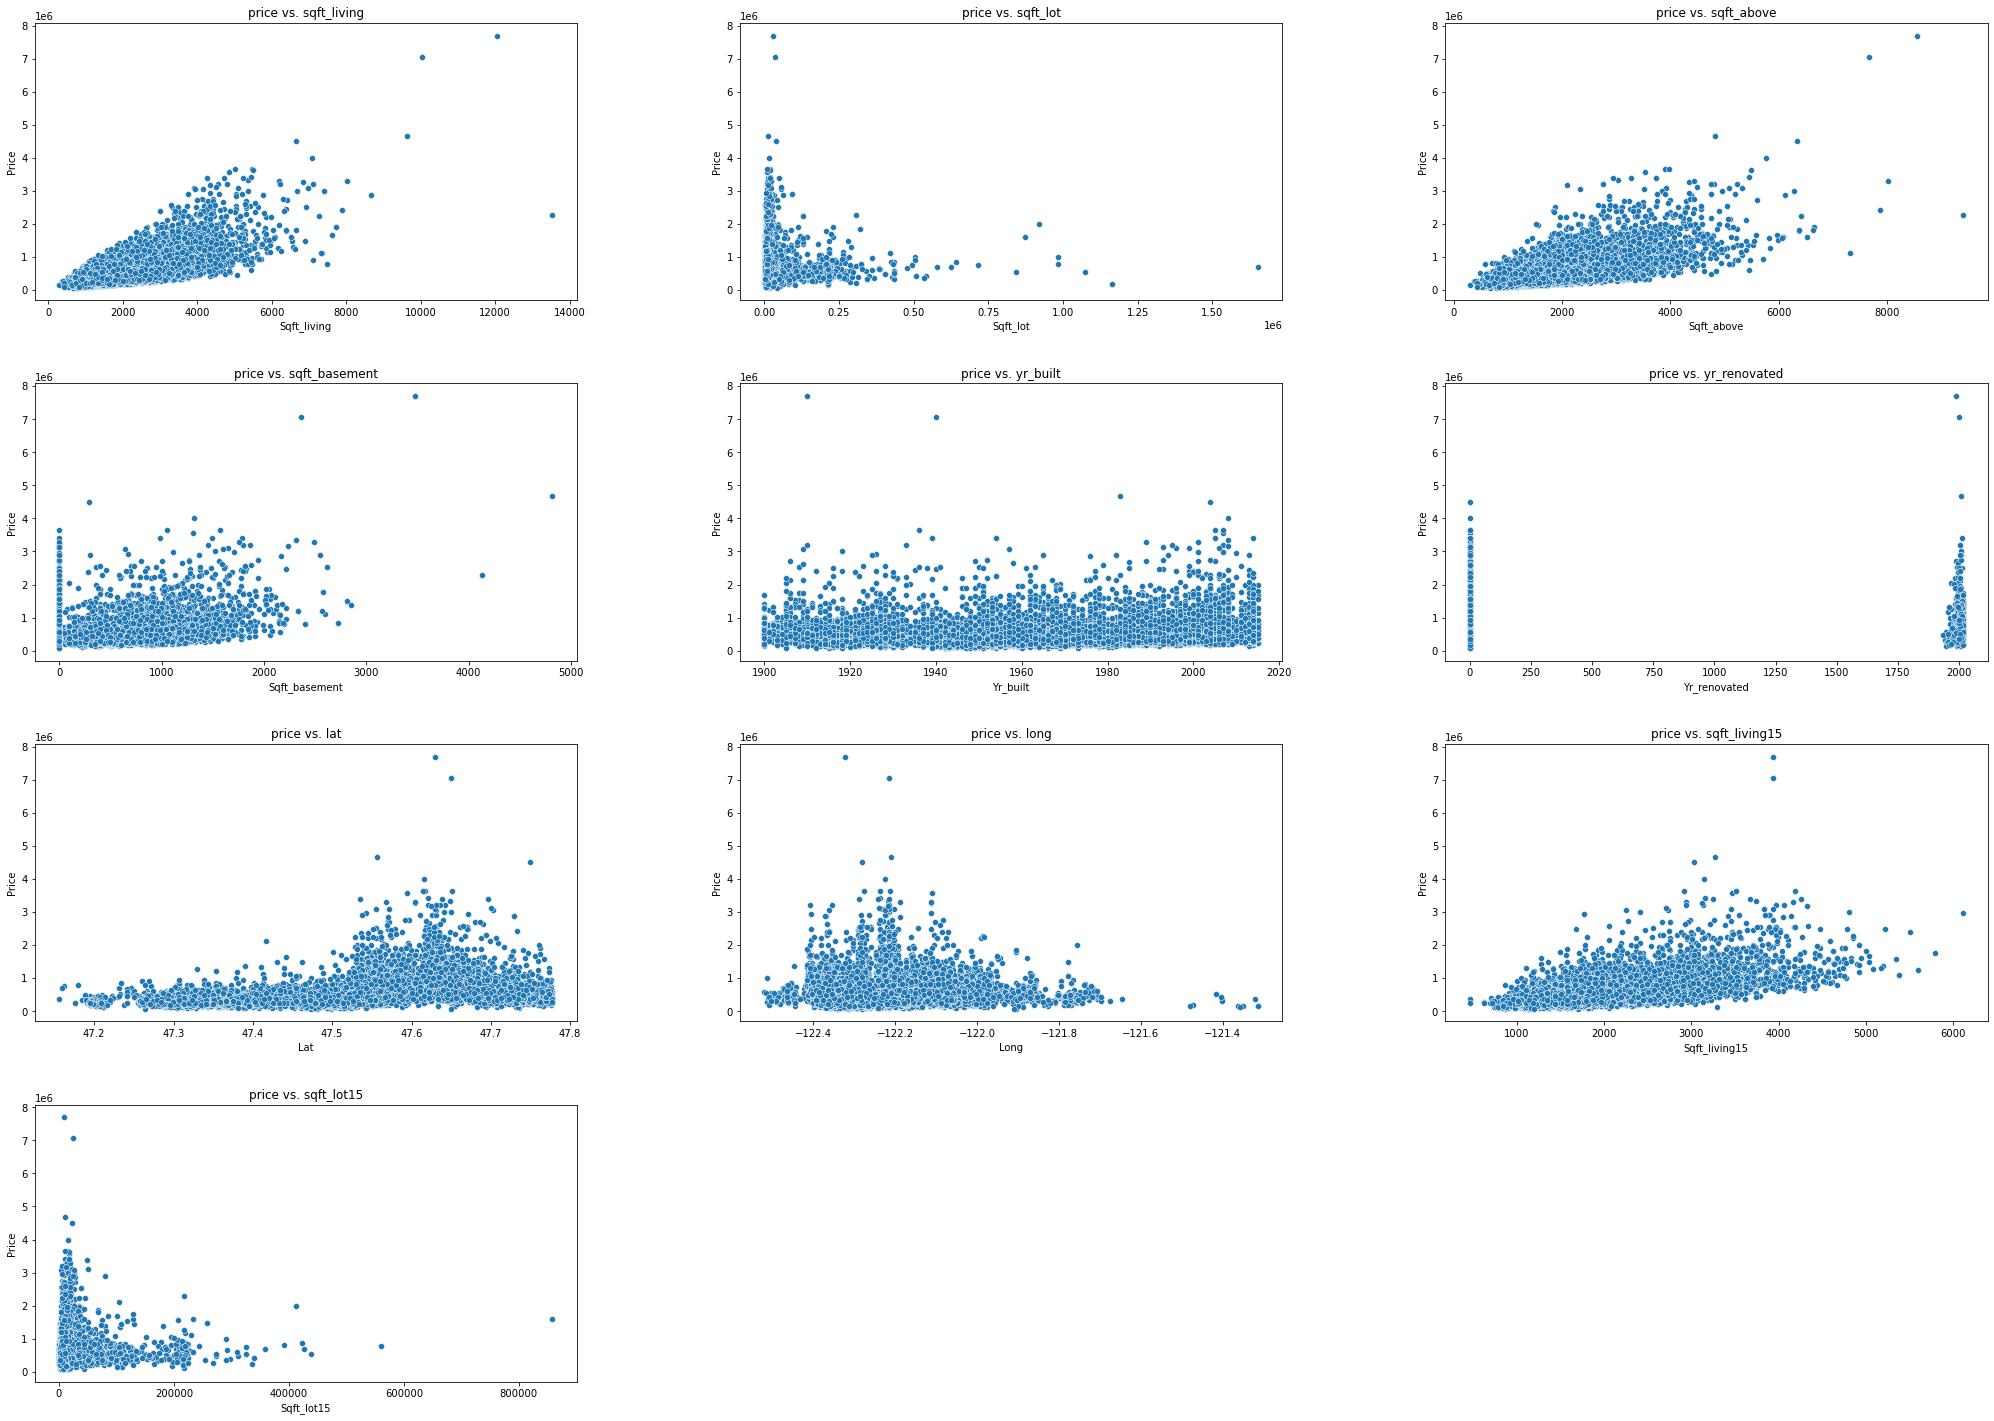

In [14]:
def plot_scatter_plot(data:pd.DataFrame, cols:list):
    """
    Plot scatter plot between price and continues variables
    
    Parameters
    ----------
    data : DataFrame
    cols : list of features
    """
    figure = plt.figure(figsize=(35,25))
    figure.subplots_adjust(wspace=0.3, hspace=0.3)

    for i, col in enumerate(cols, start=1):
        ax = figure.add_subplot(4, 3, i)
        sns.scatterplot(x=col, y='price', data=data, ax=ax)
        ax.set_title(f'price vs. {col}')
        ax.set_xlabel(col.capitalize())
        ax.set_ylabel('Price')


plot_scatter_plot(df_train, numerical_feat)
# sns.scatterplot(x='sqft_living', y='sqft_above', data=df_train)

### price - categorical vars

*Correlation:*
- There is a positive correlation between **price** and **grade** & **bathrooms** & **sqft_above**.


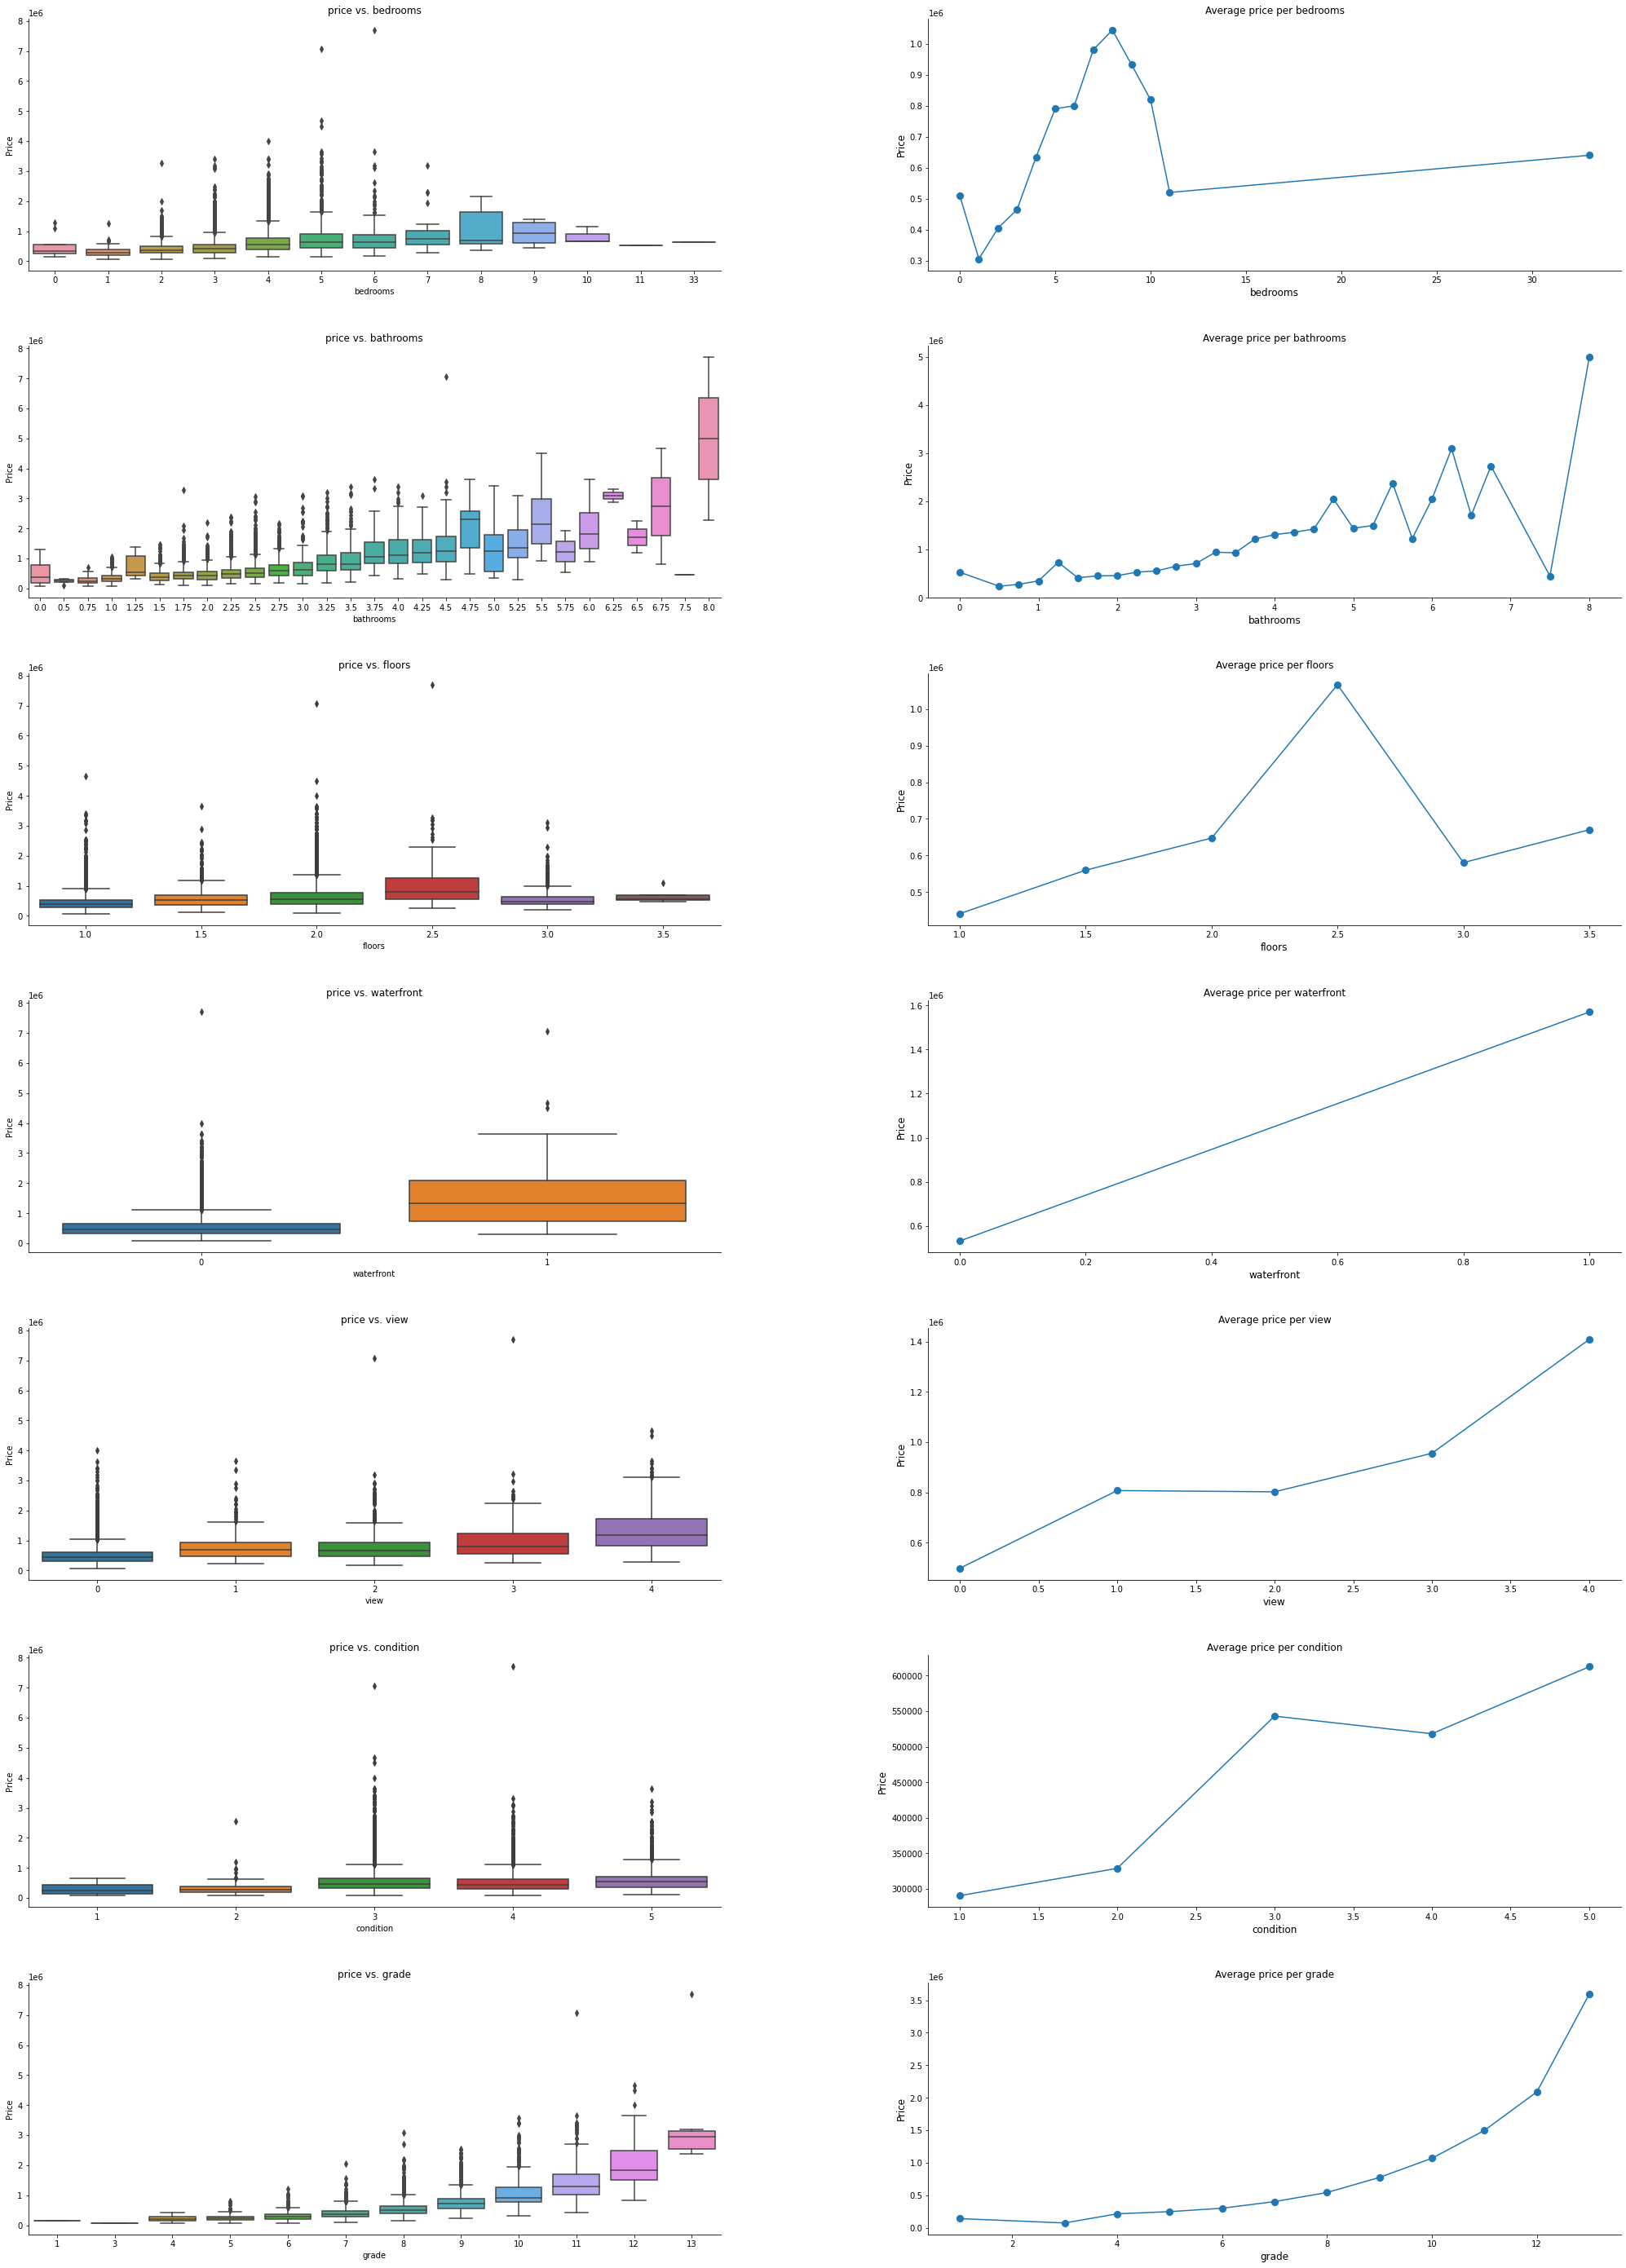

In [15]:
def plot_mean_box_plot(data:pd.DataFrame, cols:list):
    """
    Plot mean price grouped by categorical features as scatter plot
    
    Parameters
    ----------
    data : DataFrame
    cols : list of features
    """

    figure, axs = plt.subplots(nrows=len(cols), ncols=2, figsize=(35,50))
    figure.subplots_adjust(wspace=0.3, hspace=0.3)

    for i, col in enumerate(cols):
        grouped_data = data.groupby(col).mean()['price'].to_frame()
        grouped_data[col] = grouped_data.index
        grouped_data.rename(columns={0:'price'}, inplace=True)
        grouped_data.reset_index(drop=True, inplace=True)

        sns.boxplot(x=col, y='price', data=data, ax=axs[i][0])
        axs[i][0].set_title(f'price vs. {col}')
        axs[i][0].set_ylabel('Price')

        sns.lineplot(x=col, y='price', data=grouped_data, ax=axs[i][1])
        sns.scatterplot(x=col, y='price', data=grouped_data, ax=axs[i][1], s=100)
        axs[i][1].set_title(f"Average price per {col}")
        axs[i][1].set_xlabel(col, fontsize=12)
        axs[i][1].set_ylabel('Price', fontsize=12)
        sns.despine()

plot_mean_box_plot(df_train, categorical_feat)

## Correlation
Based on the **univariate analysis**, spearman correlation coefficient is the best way to check the correlation between the variables because the data is not normally distributed.


From the correlation matrix, the pairs of features with high correlation are:
- price  -> sqft_living, sqft_above, sqft_living15
- sqft_living -> sqft_above
- sqft_living -> sqft_living15
- sqft_above -> sqft_living15
- sqft_lot -> sqft_lot15




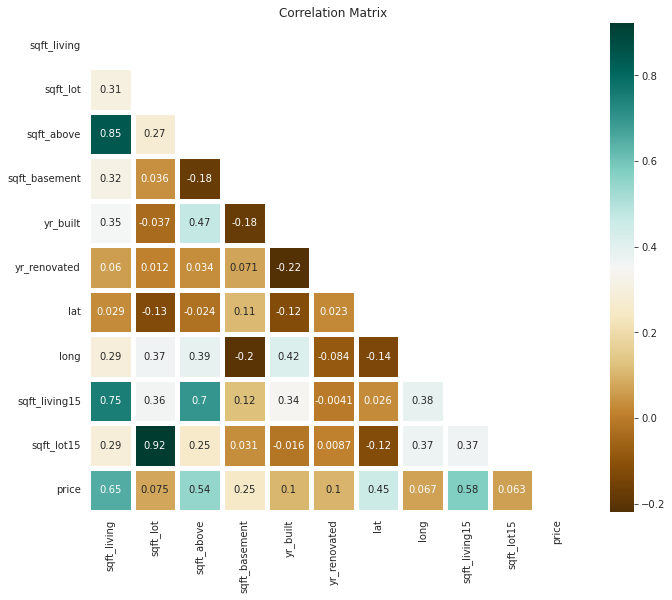

In [16]:
# Find the spearman correlation between features

corr_mat = df_train[numerical_feat.tolist() + ['price']].corr(method='spearman')


mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True
  
with sns.axes_style("whitegrid"): # white, dark, whitegrid, darkgrid, ticks
    f, ax = plt.subplots(figsize=(11, 9))
    ax = sns.heatmap(data=corr_mat, mask=mask, annot=True, annot_kws={'size':10}, linewidths=5, cmap=plt.cm.BrBG)
    ax.set_title('Correlation Matrix')

In [17]:
def find_corr_feat(corr_mat:np.array,  threshold:float) -> pd.DataFrame:
    """
    Find correlated features that have correlation value bigger than the threshold
        
        Parameters
        ----------
        data : DataFrame
        threshold : float
        
        Returns
        -------
        correlated_feat : DataFrame contains correlated features
    """
        

    corr_vars = set()

    # we search for correlated values in triangular shape
    for i in range(len(corr_mat.columns)):
        for j in range(i):
            if(abs(corr_mat.iloc[i,j]) > threshold):
                corr_vars.add((corr_mat.columns[i], corr_mat.index[j]))
        
    return pd.DataFrame(corr_vars, columns=['feat1', 'feat2'])

# corr_vars = findCorrVars(X_train_new, 0.7)
# print("The most correlate features are: ", corr_vars)
find_corr_feat(corr_mat, 0.6)

,feat1,feat2
0,sqft_lot15,sqft_lot
1,sqft_living15,sqft_above
2,sqft_above,sqft_living
3,price,sqft_living
4,sqft_living15,sqft_living


## Multicollinearity Detecting
Variable Inflation Factors (VIF):
- VIF starts at 1 and has no upper limit
- VIF = 1, no correlation between the independent variable and the other variables
- VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others

In conclusion, sqft_living15 & sqft_lot15 could be predicted by other variables so we can delete them.

In [18]:
vif = pd.DataFrame()
vif_corr_values = df_train[numerical_feat].corr()
vif.index = vif_corr_values.columns
vif["VIF"] = [variance_inflation_factor(vif_corr_values.values, i) for i in range(vif_corr_values.shape[1])]
vif["Correlated to price"] = corr_mat['price']
vif.sort_values(by='Correlated to price', ascending=False)

,VIF,Correlated to price
sqft_living,inf,0.6464759898
sqft_living15,1802.5243825948,0.5757564590
sqft_above,inf,0.5440529133
lat,1.2491739845,0.4512133590
sqft_basement,inf,0.2474881885
yr_built,4.4078155969,0.1041796333
yr_renovated,1.4029847086,0.1015469763
sqft_lot,11.6151588432,0.0751864523
long,3.7458812757,0.0669453300
sqft_lot15,12.2812740971,0.0629126270


## Multivariate

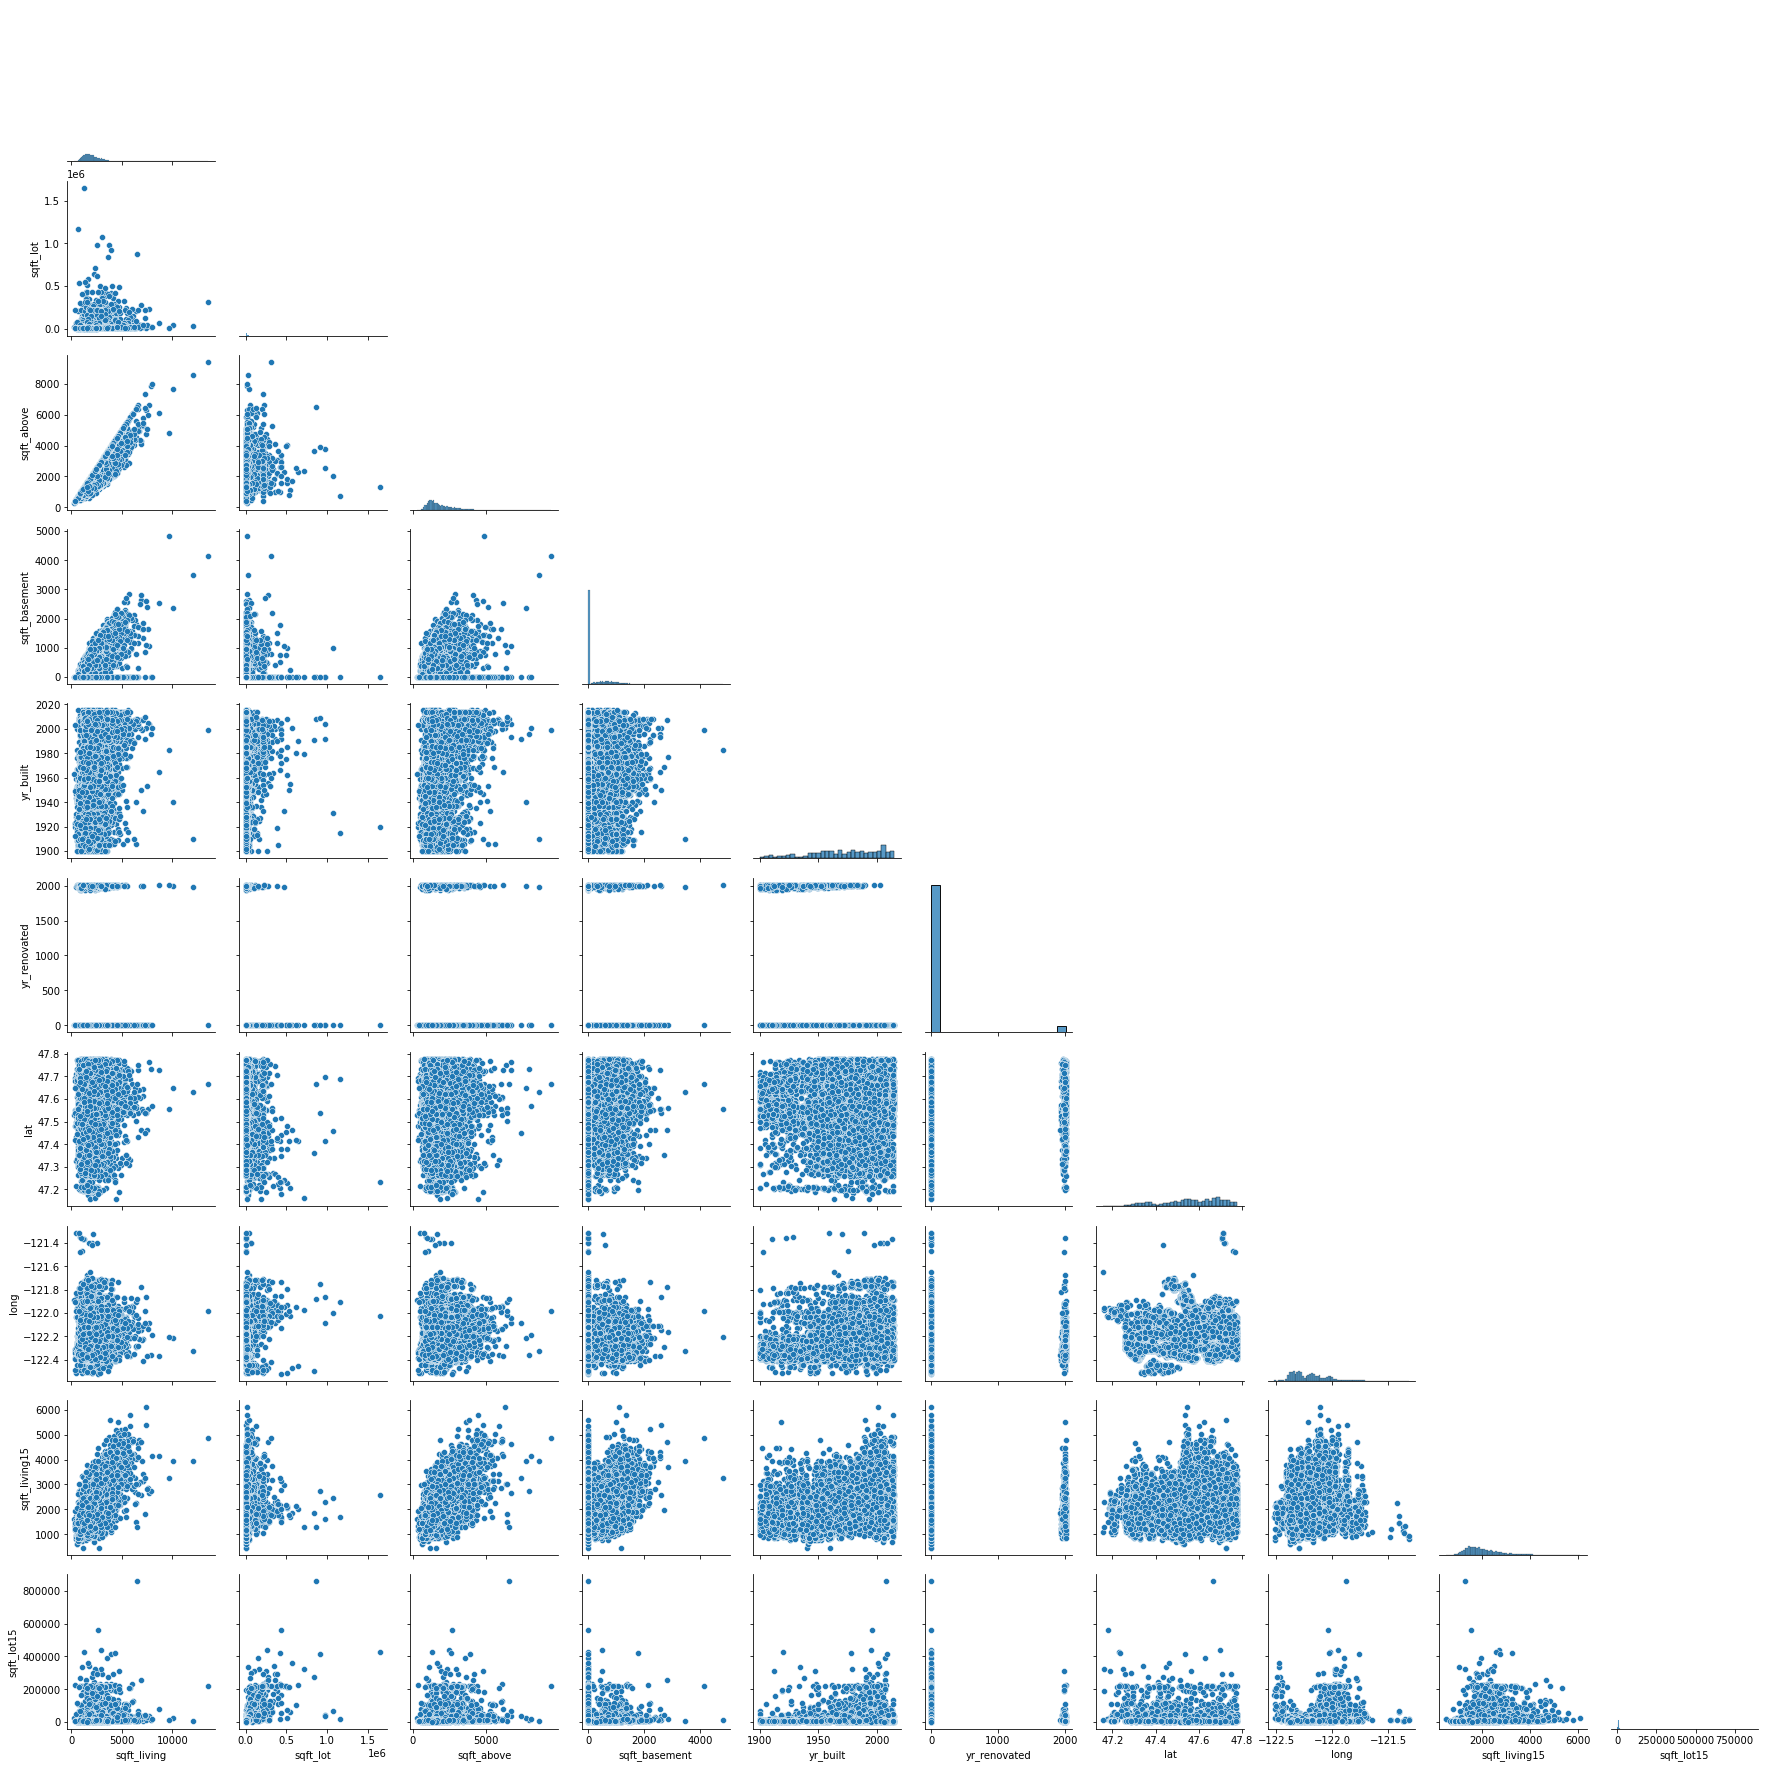

In [19]:
sns.pairplot(data=df_train[numerical_feat], corner=True, palette='RdYlGn')

## Outliers

### Using Box-whisker plot
The plotting reveals that there are some outliers at:
- price > 700000.
- sqft_living > 13000.
- sqft_lot > 1.5e6.
- sqft_basement > 4000.

In [43]:
df_train['price'].sort_values(ascending=False)

7252     7700000.0
3914     7062500.0
8092     4668000.0
2626     4500000.0
4149     4000000.0
           ...    
8274       82000.0
16198      81000.0
465        80000.0
15293      78000.0
1149       75000.0
Name: price, Length: 15126, dtype: float64

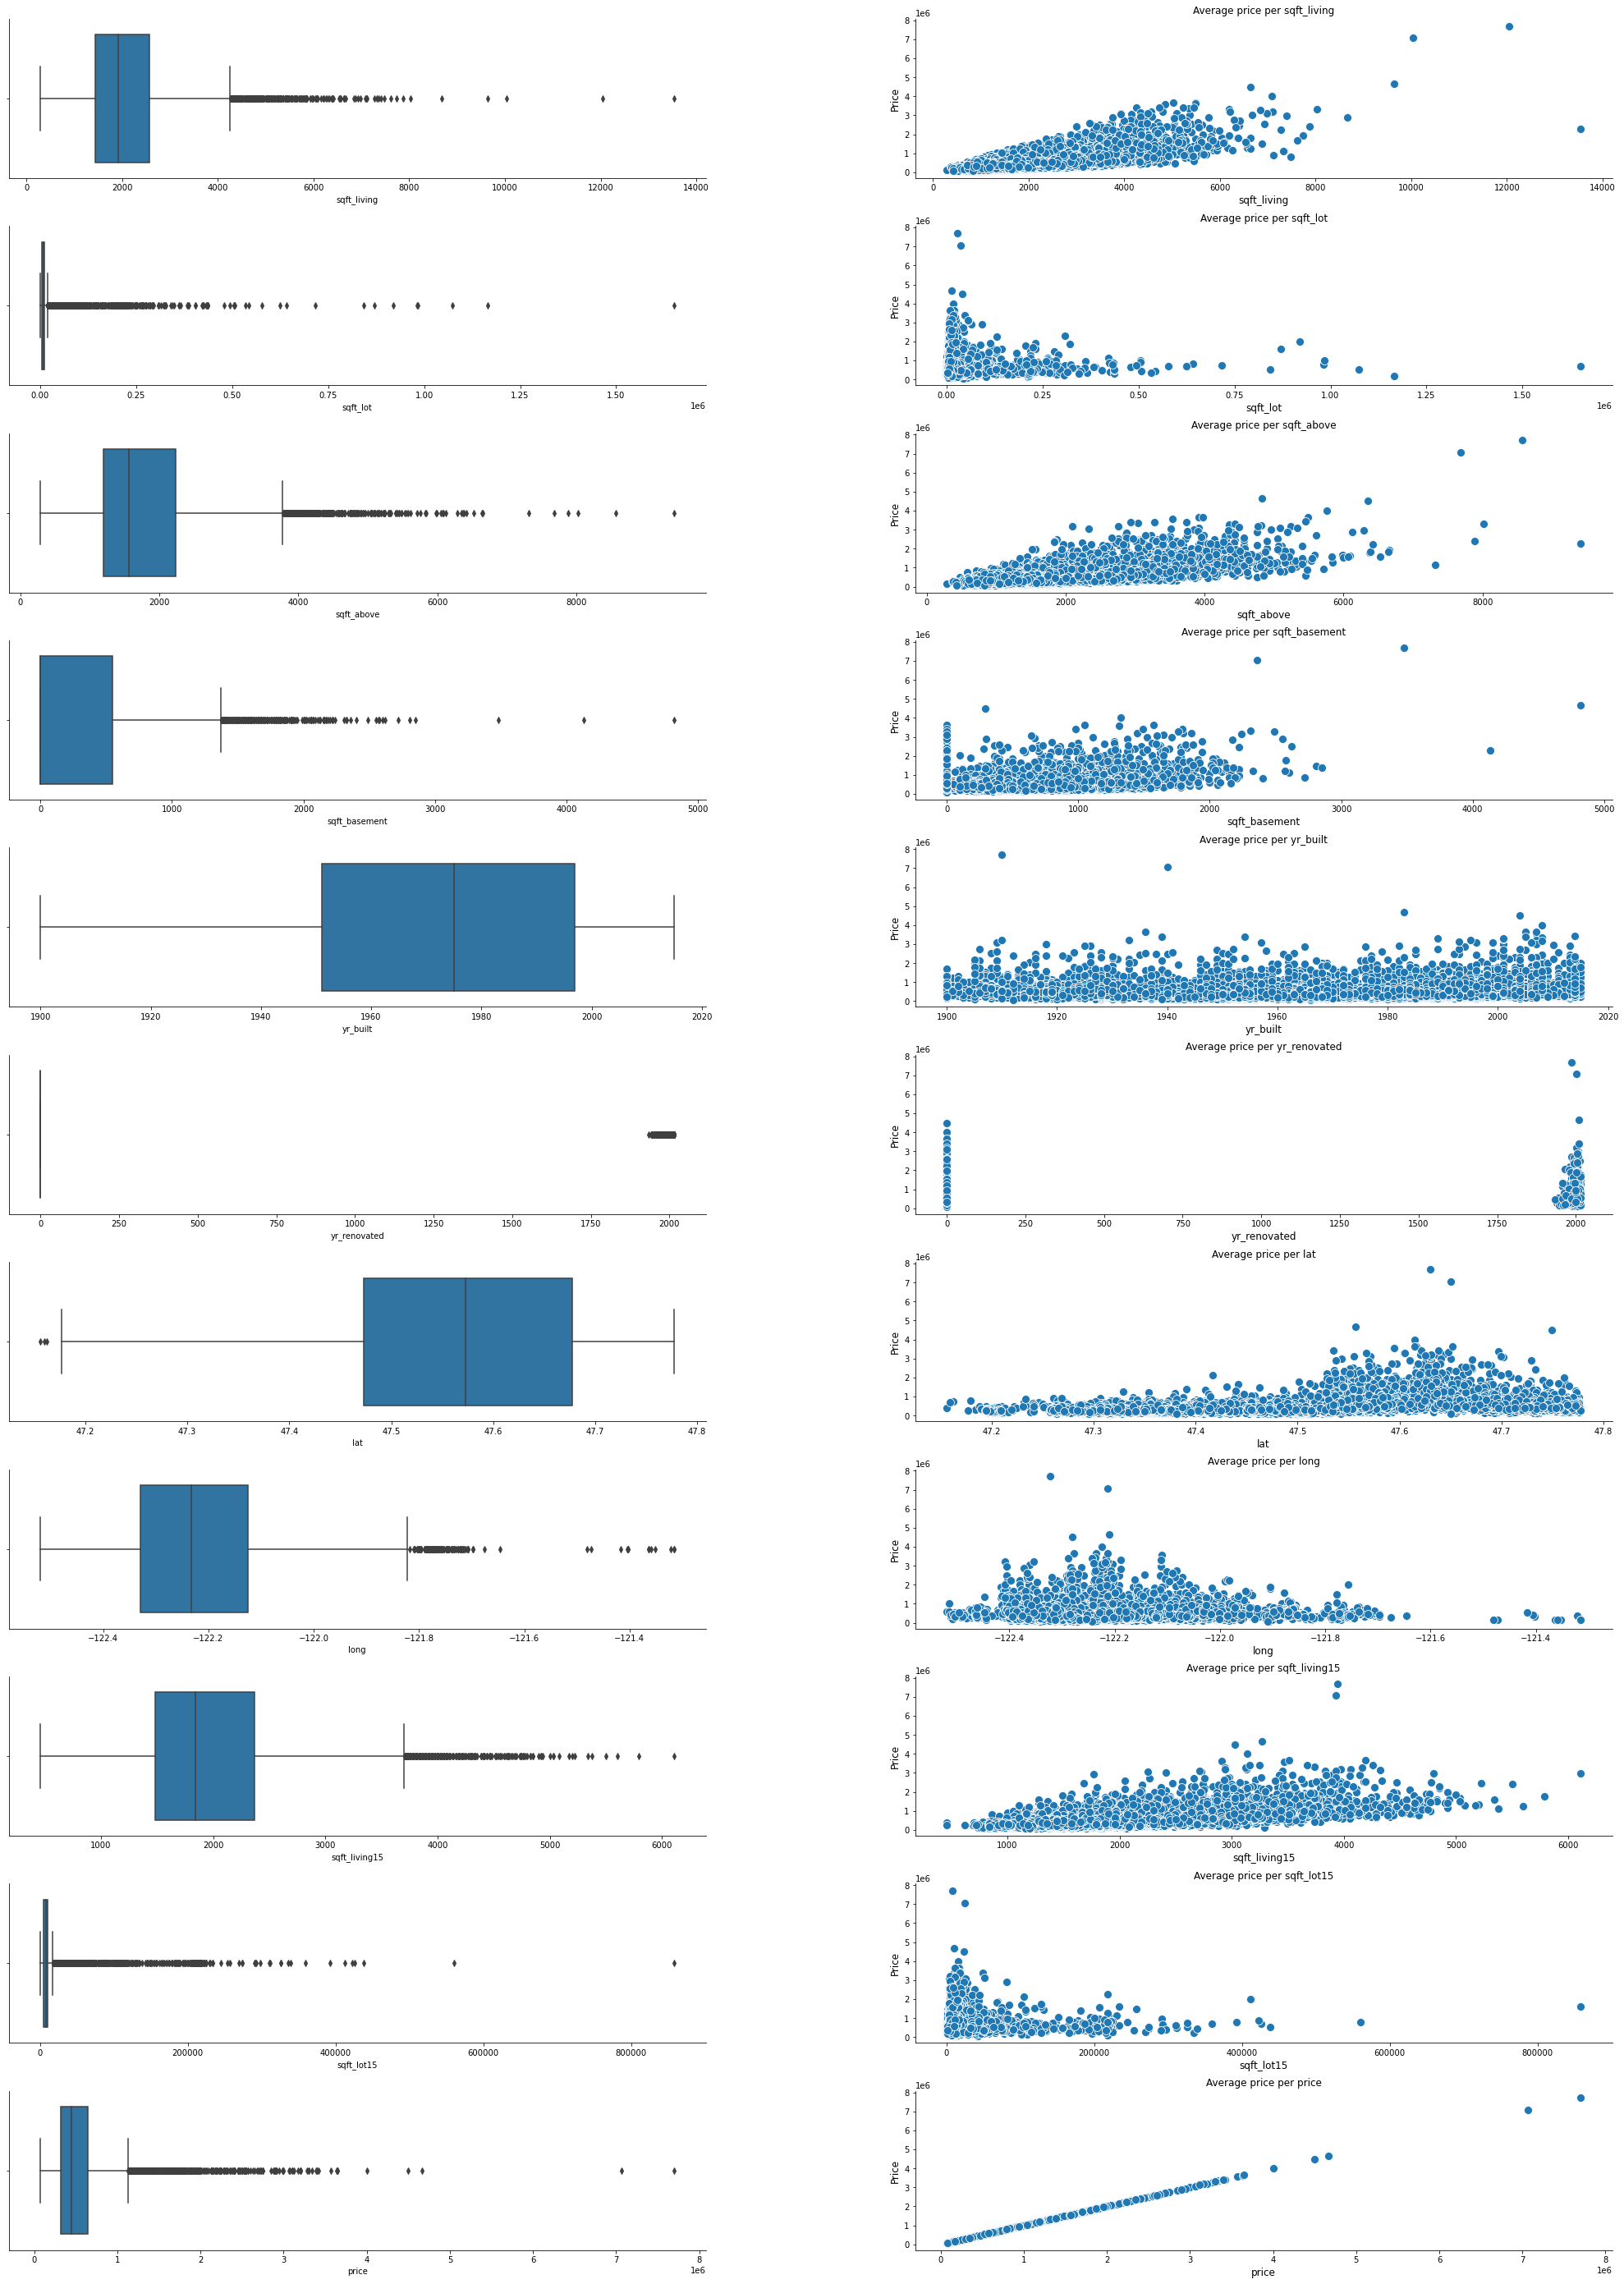

In [20]:
def plot_box_whisker_scatter(data:pd.DataFrame):
    """
    Plot box-whisker and scatter plot for numerical features
    
    Parameters
    ----------
    data : DataFrame
    """
    figure, axs = plt.subplots(nrows=len(data.columns), ncols=2, figsize=(35,50))
    figure.subplots_adjust(wspace=0.3, hspace=0.3)

    for i, col in enumerate(data.columns):
        sns.boxplot(x=col, data=data, ax=axs[i][0])

        sns.scatterplot(x=col, y='price', data=data, ax=axs[i][1], s=100)
        axs[i][1].set_title(f"Average price per {col}")
        axs[i][1].set_xlabel(col, fontsize=12)
        axs[i][1].set_ylabel('Price', fontsize=12)
        sns.despine()
        
plot_box_whisker_scatter(df_train[numerical_feat.to_list() + ['price']])



### Using Z-Score

In [28]:
def detect_outliers_zscore(series:pd.Series, threshold=3):
    zscores:np.array = np.abs(stats.zscore(series))
    dropped_index = list(np.where(zscores > threshold)[0])
    return dropped_index

    
outliers_zscore = detect_outliers_zscore(df_train['price'])

### Using IQR

In [29]:
def detect_outliers_iqr(series:pd.Series, threshold=1.5):
    quartile_1, quartile_3 = series.quantile([0.25, 0.75])

    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * threshold)
    upper_bound = quartile_3 + (iqr * threshold)
    
    dropped_index = series[(series < lower_bound) | (series > upper_bound)].index
    return dropped_index

outliers_iqr = detect_outliers_iqr(df_train['price'])

### Using percentile

In [27]:
def detect_outliers_percentile(series:pd.Series):
    quartile_10, quartile_90 = series.quantile([0.1, 0.9])
 
    dropped_index = series[(series < quartile_10) | (series > quartile_90)].index
    return dropped_index

outliers_perc = detect_outliers_percentile(df_train['price'])

### Outliers Removing

In [63]:
index_condition = df_train[
    (df_train['price']>7_000_000) | (df_train['sqft_living']>13_000) | (df_train['sqft_lot']>1.5e6) | (df_train['sqft_basement']>4_000) | (df_train['sqft_lot15']>8_00_000)
].index
df_train_no_outliers = df_train.drop(index= index_condition)

## Train/Test split

In [ ]:
# Splite data to inpdependent variables and traget
X_train, y_train = df_train.drop(columns=['price']), df_train['price']
X_test, y_test = df_test.drop(columns=['price']), df_test['price']


# Modeling

In [ ]:
X_train_new = X_train.copy()
y_train_new = y_train.copy()
X_test_new = X_test.copy()
y_test_new = y_test.copy()

## Features Transformation
#### We will transform some continues features to normal distribution

In [ ]:
rng = np.random.RandomState(304)

# n_quantiles is set to the training set size rather than the default value
# to avoid a warning being raised by this example
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',
                         random_state=rng)

X_train_new[numerical_feat] = qt.fit_transform(X_train_new[numerical_feat])
X_test_new[numerical_feat] = qt.transform(X_test_new[numerical_feat])

y_train_new = pd.Series(qt.fit_transform(y_train_new.to_numpy()[:,np.newaxis]).ravel(), name='price')
y_test_new = pd.Series(qt.transform(y_test_new.to_numpy()[:,np.newaxis]).ravel(), name='price')


## Features scaling

In [ ]:
scaler = StandardScaler()
X_train_new[numerical_feat] = scaler.fit_transform(X_train_new[numerical_feat], y_train_new)
X_test_new[numerical_feat] = scaler.transform(X_test_new[numerical_feat])

y_train_new = pd.Series(scaler.fit_transform(y_train_new.to_numpy()[:,np.newaxis]).ravel(), name='price')
y_test_new = pd.Series(scaler.transform(y_test_new.to_numpy()[:,np.newaxis]).ravel(), name='price')

## Features selection

### 1. Filter method

In [ ]:
skb_freg = SelectKBest(score_func=f_regression, k=13)
skb_freg.fit(X_train_new, y_train_new)
skb_freg_selected_feat = pd.DataFrame({'score':skb_freg.scores_, 'p-value':skb_freg.pvalues_, 'accepted':skb_freg.get_support()}, index=X_train_new.columns)
skb_freg_selected_feat[skb_freg.get_support()]

### 2. Feature importance method

In [ ]:
skb_mi = SelectKBest(score_func=mutual_info_regression, k=13)
skb_mi.fit(X_train_new, y_train_new)
skb_mi_selected_feat = pd.DataFrame({'score':skb_mi.scores_, 'accepted':skb_mi.get_support()}, index=X_train_new.columns)
skb_mi_selected_feat[skb_mi.get_support()]

In [ ]:
skb = skb_freg
X_train_new = pd.DataFrame(skb.transform(X_train_new), columns=X_train_new.columns[skb.get_support()])
X_test_new = pd.DataFrame(skb.transform(X_test_new), columns=X_test_new.columns[skb.get_support()])


In [ ]:
# X_train_new.drop(columns=corr_vars[0], inplace=True)
# X_test_new.drop(columns=corr_vars[0], inplace=True)

In [ ]:
gradientBossting_model = GradientBoostingRegressor(n_estimators=100, max_depth = 6)
gradientBossting_model.fit(X_train_new,y_train_new)
print("Model train score: ",gradientBossting_model.score(X_train_new,y_train_new))
print("Model validation score: ",gradientBossting_model.score(X_test_new, y_test_new))
print("MSE validation: ", mean_absolute_error(y_test_new, gradientBossting_model.predict(X_test_new)))

In [ ]:
# Calculate testing score/loss for gradientBossting model 

# Make zeros matrix of the shabe of number of estimators
test_error = np.zeros(gradientBossting_model.n_estimators, dtype=np.float64)

# Calculate score for each estimator
for i, y_pred in enumerate(gradientBossting_model.staged_predict(X_test_new)):
    test_error[i] = gradientBossting_model.loss_(y_test_new, y_pred)


In [ ]:
# Plotting score for training and testing
estimators = np.arange(gradientBossting_model.n_estimators)+1

plt.figure(figsize=(8,6))
plt.plot(estimators, gradientBossting_model.train_score_, label='Train score')
plt.plot(estimators, test_error, label='Test score')
plt.xlabel('Number of estimators')
plt.ylabel('Error')
plt.legend()

#### From the above plot we can determine that the number of estimators shoude be selected about 60 estimators to prevent from going to overfitting problem